In [ ]:
!pip install filterpy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Download Files

In [ ]:
# I will create a different git repo for this work, so clone to a separate folder
!git clone https://github.com/cfotache/pytorch_objectdetecttrack.git

Cloning into 'pytorch_objectdetecttrack'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 36 (delta 5), reused 2 (delta 2), pack-reused 19
Receiving objects: 100% (36/36), 2.88 MiB | 7.59 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
%ls

pytorch_objectdetecttrack/  sample_data/


## Download Weights

In [ ]:
%cd /content/.config

/content/.config


In [ ]:
%%sh
bash /content/pytorch_objectdetecttrack/config/download_weights.sh

--2024-04-13 09:57:29--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

     0K .......... .......... .......... .......... ..........  0% 2.67M 89s
    50K .......... .......... .......... .......... ..........  0% 2.64M 89s
   100K .......... .......... .......... .......... ..........  0%  137M 60s
   150K .......... .......... .......... .......... ..........  0% 11.3M 50s
   200K .......... .......... .......... .......... ..........  0% 3.45M 54s
   250K .......... .......... .......... .......... ..........  0%  169M 45s
   300K .......... .......... .......... .......... ..........  0%  173M 39s
   350K .......... .......... .......... .......... ..........  0% 13.7M 36s
   400K .......... .......... .......... .......... ...

In [ ]:
%cd /content/pytorch_objectdetecttrack

/content/pytorch_objectdetecttrack


## Imports

In [ ]:
from models import *
from utils import *

import os, sys, time, datetime, random

import torch
import torchvision.transforms as trf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [ ]:
config_path = "config/yolov3.cfg"
weights_path = "/content/.config/yolov3.weights"
class_path = "config/coco.names"  # 80 classes

img_size = 416
conf_thresh = 0.8 # confidence threshold
nms_thresh = 0.4  # non-max suppression threshold

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

In [ ]:
def show_image(image):
  """Display a single tensor or np array image"""
  fig, ax = plt.subplots(figsize=(12, 9))
  ax.set_yticks([]); ax.set_xticks([])
  ax.imshow(image.permute(1,2,0))

In [ ]:
def detect_image(img):
  """Runs Image detection on a single PIL Image"""
  # scale and pad image
  ratio = min(img_size/img.size[0], img_size/img.size[1])
  resized_w = round(img.size[0] * ratio)
  resized_h = round(img.size[1] * ratio)

  trfms = trf.Compose([trf.Resize((resized_h, resized_w)),
                       # left/right and top/bottom
                       trf.Pad((max(0, int((resized_h-resized_w)/2)),
                                max(0, int((resized_w-resized_h)/2)))),
                       trf.ToTensor()])

  img_tensor = trfms(img)
  # show a preview of the image
  # show_image(img_tensor)
  img_tensor = img_tensor.unsqueeze(0)

  with torch.no_grad():
    detections = model(img_tensor.cuda())
    detections = utils.non_max_suppression(detections, 80, conf_thresh, nms_thresh)

  return detections[0]

/content/pytorch_objectdetecttrack/models.py:142: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  scaled_anchors = FloatTensor([(a_w / stride, a_h / stride) for a_w, a_h in self.anchors])


Inference Time: 0:00:01.343144


<ipython-input-17-02bd7e5a1da8>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]


<Figure size 640x480 with 0 Axes>

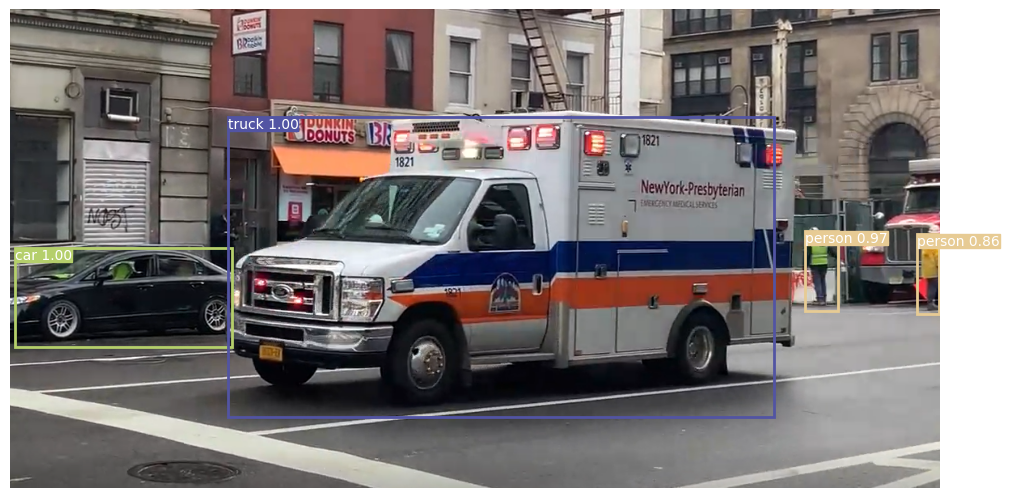

In [ ]:
from IPython.display import display

# load image and get detections
img_path = "/content/embulence.png"
start_time = time.time()
img = Image.open(img_path)
# Convert image to RGB if it has an alpha channel
if img.mode == 'RGBA':
    img = img.convert('RGB')
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - start_time)
print(f"Inference Time: {inference_time}")

# Bounding Box Colours
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

# Create Image
img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
  unique_labels = detections[:, -1].cpu().unique()
  n_cls_preds = len(unique_labels)
  bbox_colors = random.sample(colors, n_cls_preds)
  for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
    x1, y1 = x1.detach().cpu(), y1.detach().cpu()
    x2, y2 = x2.detach().cpu(), y2.detach().cpu()
    conf, cls_conf = conf.detach().cpu(), cls_conf.detach().cpu()

    box_h = ((y2 - y1) / unpad_h) * img.shape[0]
    box_w = ((x2 - x1) / unpad_w) * img.shape[1]
    y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
    x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]

    color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                             edgecolor=color, facecolor="none")
    ax.add_patch(bbox)
    plt.text(x1, y1, s=classes[int(cls_pred)] + " {0:.2f}".format(conf),
             color="white",
             verticalalignment="top",
             bbox={'color': color, 'pad': 0})

plt.axis("off")
plt.savefig(img_path.replace(".jpg", "-det.jpg"),
            bbox_inches="tight", pad_inches=0.0)
plt.show()